In [11]:
import pickle
import pandas as pd
from collections import defaultdict, OrderedDict, Counter
import time
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import re
import os
import scipy

%matplotlib inline

import matplotlib
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate, cross_val_predict,  GridSearchCV, StratifiedKFold
from sklearn import metrics

In [13]:
from sklearn.metrics import confusion_matrix,roc_curve, auc
import matplotlib.patches
import matplotlib.font_manager
import matplotlib

In [14]:
# draw out accuracy bar chart (small!)
# draw out roc auc curves in one plot
# draw out number of selected features in bar chart (small!)

In [15]:
metadata = [{ 'spe':'staphylococcus','keyword':'pangenome', 'directory': '/home/yara/Documents/cystic_fibrosis/data/staphylococcus', 'FT_LRI':'FT_LRI', 'C':1, 'color': 'lightslategrey'},
            {'spe':'staphylococcus','keyword':'', 'directory': '/home/yara/Documents/cystic_fibrosis/data/staphylococcus', 'FT_LRI':'FT_LRI', 'C':1, 'color':'black'},
            {'spe':'pseudomonas','keyword':'pangenome', 'directory': '/home/yara/Documents/cystic_fibrosis/data/pseudomonas', 'FT_LRI':'FT_LRI_f2', 'C':2, 'color':'lightblue'},
           {'spe':'pseudomonas','keyword':'', 'directory': '/home/yara/Documents/cystic_fibrosis/data/pseudomonas', 'FT_LRI':'FT_LRI_f2', 'C':0.5, 'color':'darkblue'}]

0.9891566265060241 0.9326923076923077
0.9903614457831326 0.9182692307692307
0.9718804920913884 0.8461538461538461
0.9718804920913884 0.8811188811188811


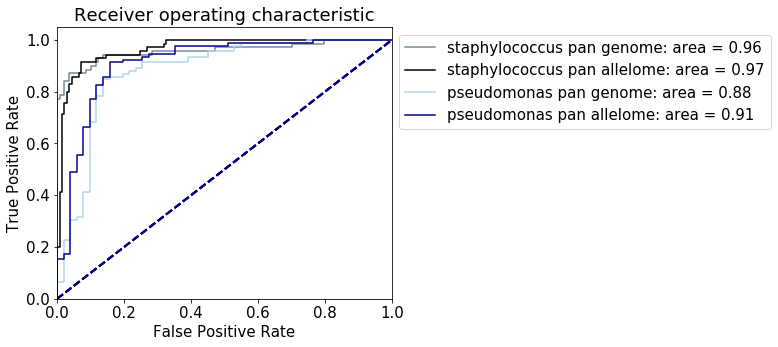

In [16]:
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, ax = plt.subplots(1,1, figsize = (6, 5))

accuracy_summary = []
for d in metadata:
    
    directory, keyword, spe, C = d['directory'], d['keyword'], d['spe'], d['C']
    input_matrix = scipy.sparse.load_npz('%s/allele_matrix/allele_matrix.npz'%directory).todense().T if keyword == '' else np.matrix(pd.read_csv('%s/pangenome/pangenome_matrix.csv'%(directory)).T)
    FT_LRI = pd.read_csv('%s/%s.csv'%(directory, d['FT_LRI']), dtype = {'Genome ID':str}).set_index('Genome ID')
    if keyword == '':
        col_rows = pickle.load(open('%s/allele_matrix/col_rows.p'%directory, 'rb'))
        gid_order = col_rows[0]
        FT_LRI = FT_LRI.loc[gid_order].reset_index()

        
    output_d = '%s/machine_learning/input_data_%s.npz'%(directory, keyword) if keyword != '' else '%s/machine_learning/input_data.npz'%(directory)
    npzfile = np.load(output_d)

    output_d = '%s/machine_learning/selected_features_final_trial_2_%s.csv'%(directory, keyword) if keyword != '' else '%s/machine_learning/selected_features_final_trial_2.csv'%(directory)
    selected_features_final = pd.read_csv(output_d)

    labels = FT_LRI['cystic_fibrosis_status']
    selected_features = selected_features_final['Unnamed: 0']
    data_FS, data_holdout = input_matrix[npzfile['train_index'],:], input_matrix[npzfile['holdout_index'],:]
    labels_FS, labels_holdout = labels[npzfile['train_index']], labels[npzfile['holdout_index']]

    skf = StratifiedKFold(n_splits=10)
    clf = LinearSVC(penalty="l2", max_iter = 20000, class_weight = 'balanced', C = C)
    predicted = cross_val_predict(clf, data_FS[:,selected_features], labels_FS, cv=skf)
    training_accuracy = metrics.accuracy_score(labels_FS, predicted)
    
    clf_train = LinearSVC(penalty="l2", max_iter = 20000, class_weight = 'balanced', C = C)
    clf_train.fit(data_FS[:,selected_features], labels_FS)
    validation_accuracy = clf_train.score(data_holdout[:,selected_features], labels_holdout)
    
    accuracy_summary.append({'spe':spe, 'matrix':keyword if keyword !='' else 'allelome', 'training_accuracy':100*training_accuracy, 'validation_accuracy':100*validation_accuracy,
                             'no_features': len(selected_features_final)})
    
    print(training_accuracy, validation_accuracy)
    

    lw = 2
    y_score = clf.fit(data_FS[:,selected_features], labels_FS).decision_function(data_holdout[:,selected_features])
    fpr, tpr, _ = roc_curve(labels_holdout, y_score)
    roc_auc_multi = auc(fpr, tpr)
    
    l = 'pan allelome' if keyword == '' else 'pan genome'
    ax.plot(fpr, tpr, color = d['color'], label='%s %s: area = %s'%(spe, l, str(round(roc_auc_multi, 2))))
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(bbox_to_anchor = (1,1))
fig.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/ROC_AUC_curves_all.svg')

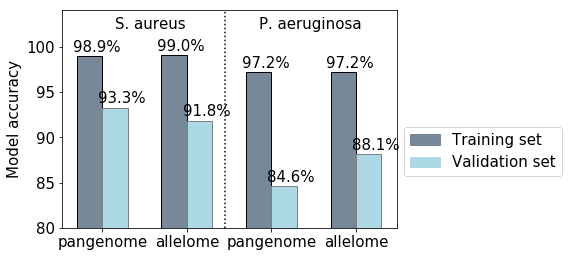

In [17]:
accuracy_df = pd.DataFrame(accuracy_summary)
for i, row in accuracy_df.iterrows():
    plt.bar([i, i+0.3], [row['training_accuracy'], row['validation_accuracy']], width = 0.3, edgecolor  = ['black', 'gray'], color = ['lightslategrey','lightblue'])
    plt.text(i-0.2, 0.5+row['training_accuracy'], '%s%%'%str(round(row['training_accuracy'], 1)))
    plt.text(i+0.1, 0.5+row['validation_accuracy'],'%s%%'%str(round(row['validation_accuracy'], 1)))
    
plt.text(0.3, 102, 'S. aureus')
plt.text(2, 102, 'P. aeruginosa')
plt.axvline(1.6, linestyle = 'dotted', color= 'black')
plt.xticks([x+0.15 for x in range(4)], accuracy_df['matrix'])
plt.ylim(80, 104)
plt.ylabel('Model accuracy')
plt.legend(handles = [mpatches.Patch(color = 'lightslategrey', label = 'Training set'),
                     mpatches.Patch(color = 'lightblue', label = 'Validation set')],
          bbox_to_anchor = (1,0.5))
plt.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/model_accuracy_all.svg')

In [107]:
accuracy_df.loc[accuracy_df['matrix']=='pangenome']['no_features']

,matrix,no_features,spe,training_accuracy,validation_accuracy
0,pangenome,86,staphylococcus,98.915663,93.269231
1,allelome,40,staphylococcus,99.036145,91.826923
2,pangenome,105,pseudomonas,97.188049,84.615385
3,allelome,60,pseudomonas,97.188049,88.111888


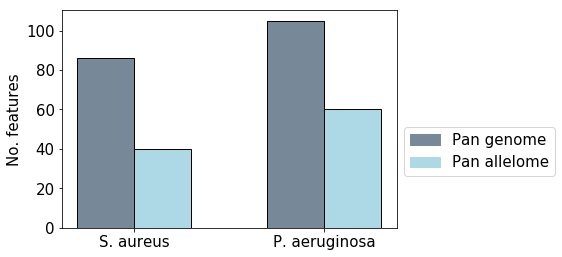

In [18]:
plt.bar([1,2], accuracy_df.loc[accuracy_df['matrix']=='pangenome']['no_features'], width = 0.3, color = ['lightslategrey','lightslategrey'], edgecolor = 'black')
plt.bar([1.3,2.3], accuracy_df.loc[accuracy_df['matrix']=='allelome']['no_features'], width = 0.3,  color = ['lightblue','lightblue'], edgecolor = 'black')
plt.ylabel('No. features')
plt.legend(handles = [mpatches.Patch(color = 'lightslategrey', label = 'Pan genome'),
                     mpatches.Patch(color = 'lightblue', label = 'Pan allelome')],
          bbox_to_anchor = (1,0.5))
plt.xticks([1.15,2.15], ['S. aureus', 'P. aeruginosa'])
plt.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/model_no_features_all.svg')